## Evaluation Metrics

In this step, we aggregate the values of **TP**, **FP**, **TN**, and **FN** (True Positive, False Positive, True Negative, False Negative) for different groups of the Dragon_Pi dataset and compute classical evaluation metrics commonly used in intrusion detection.

### Basic Definitions

- **TP (True Positives)**: attacks correctly detected.  
- **FP (False Positives)**: benign traffic incorrectly classified as attack.  
- **TN (True Negatives)**: benign traffic correctly identified.  
- **FN (False Negatives)**: attacks that the system failed to detect.

### Formulas Used

The metrics below follow standard definitions widely adopted in the intrusion detection and machine-learning literature.

- **Accuracy**  
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- **Detection Rate (DR or Recall)**  
$$
\text{DR} = \frac{TP}{TP + FN}
$$

- **False Alarm Rate (FAR)**  
$$
\text{FAR} = \frac{FP}{FP + TN}
$$

- **Precision**  
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

- **F1-Score**  
$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{DR}}{\text{Precision} + \text{DR}}
$$

- **Balanced Accuracy**  
$$
\text{BalancedAccuracy} = \frac{1}{2}\left( 
\frac{TP}{TP+FN} + \frac{TN}{TN+FP} 
\right)
$$

### Purpose of This Cell

To consolidate the aggregated TP/FP/TN/FN values from all threshold-based experiments and generate two final tables:
1. **summary_raw.csv** – aggregated confusion-matrix counts for each group.  
2. **summary_metrics.csv** – computed evaluation metrics derived from these values.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
base_path = Path("results_threshold")
summary_files = list(base_path.rglob("summary.csv"))
rows = []

for file in summary_files:
    df = pd.read_csv(file)
    attack_dir = file.parent.name
    device = file.parent.parent.name
    attack_type = attack_dir.split("_")[-2] if "_" in attack_dir else attack_dir
    df["device"] = device
    df["attack_dir"] = attack_dir
    df["attack_type"] = attack_type
    rows.append(df)

results_df = pd.concat(rows, ignore_index=True)

group_map = {
    "Full Dragon_Pi": (results_df["device"].isin(["dragon", "pi"])),
    "Dragon Only": (results_df["device"] == "dragon"),
    "Pi Only": (results_df["device"] == "pi"),
    "Portscan Only": (results_df["attack_type"].str.contains("portscan", case=False)),
    "DoS Only": (results_df["attack_type"].str.contains("dos|synflood", case=False)),
    "Bruteforce Only": (results_df["attack_type"].str.contains("bruteforce", case=False)),
    "CTF Only": (results_df["attack_type"].str.contains("ctf", case=False)),
}

agg_rows = []

for name, mask in group_map.items():
    subset = results_df[mask]
    if subset.empty:
        continue

    TP = subset["TP"].sum()
    FP = subset["FP"].sum()
    TN = subset["TN"].sum()
    FN = subset["FN"].sum()

    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    DR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FAR = FP / (FP + TN) if (FP + TN) > 0 else 0
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    F1 = 2 * Precision * DR / (Precision + DR) if (Precision + DR) > 0 else 0
    BalancedAccuracy = (DR + (TN / (TN + FP))) / 2 if (TN + FP) > 0 else 0

    agg_rows.append({
        "Data": name,
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "Accuracy": round(Accuracy, 3),
        "DR": round(DR, 3),
        "FAR": round(FAR, 3),
        "Precision": round(Precision, 3),
        "F1": round(F1, 3),
        "BalancedAccuracy": round(BalancedAccuracy, 3)
    })

results_metrics_df = pd.DataFrame(agg_rows)

table_raw = results_metrics_df[["Data", "TP", "FP", "TN", "FN"]]
table_metrics = results_metrics_df[[
    "Data", "Accuracy", "DR", "FAR", "Precision", "F1", "BalancedAccuracy"
]]

display(table_raw)
display(table_metrics)

out_dir = Path("results_threshold") / "final_metrics"
out_dir.mkdir(parents=True, exist_ok=True)
table_raw.to_csv(out_dir / "summary_raw.csv", index=False)
table_metrics.to_csv(out_dir / "summary_metrics.csv", index=False)


,Data,TP,FP,TN,FN
0,Full Dragon_Pi,5475,242,9621,2722
1,Dragon Only,3006,116,6776,1442
2,Pi Only,2469,126,2845,1280
3,Portscan Only,292,47,1615,986
4,DoS Only,125,3,220,12
5,Bruteforce Only,3863,144,6156,1297
6,CTF Only,1195,48,1630,427


,Data,Accuracy,DR,FAR,Precision,F1,BalancedAccuracy
0,Full Dragon_Pi,0.836,0.668,0.025,0.958,0.787,0.822
1,Dragon Only,0.863,0.676,0.017,0.963,0.794,0.829
2,Pi Only,0.791,0.659,0.042,0.951,0.778,0.808
3,Portscan Only,0.649,0.228,0.028,0.861,0.361,0.600
4,DoS Only,0.958,0.912,0.013,0.977,0.943,0.949
5,Bruteforce Only,0.874,0.749,0.023,0.964,0.843,0.863
6,CTF Only,0.856,0.737,0.029,0.961,0.834,0.854


**No Skill Line:** Represents the performance of a completely random detector with no ability to distinguish normal behavior from attacks.  
- In **ROC curves**, it appears as the diagonal where *TPR = FPR*, indicating chance-level performance.  
- In **Precision–Recall curves**, it corresponds to the base rate of positive samples in the dataset.  
Any point above these lines shows that the threshold-based detector performs better than random guessing.


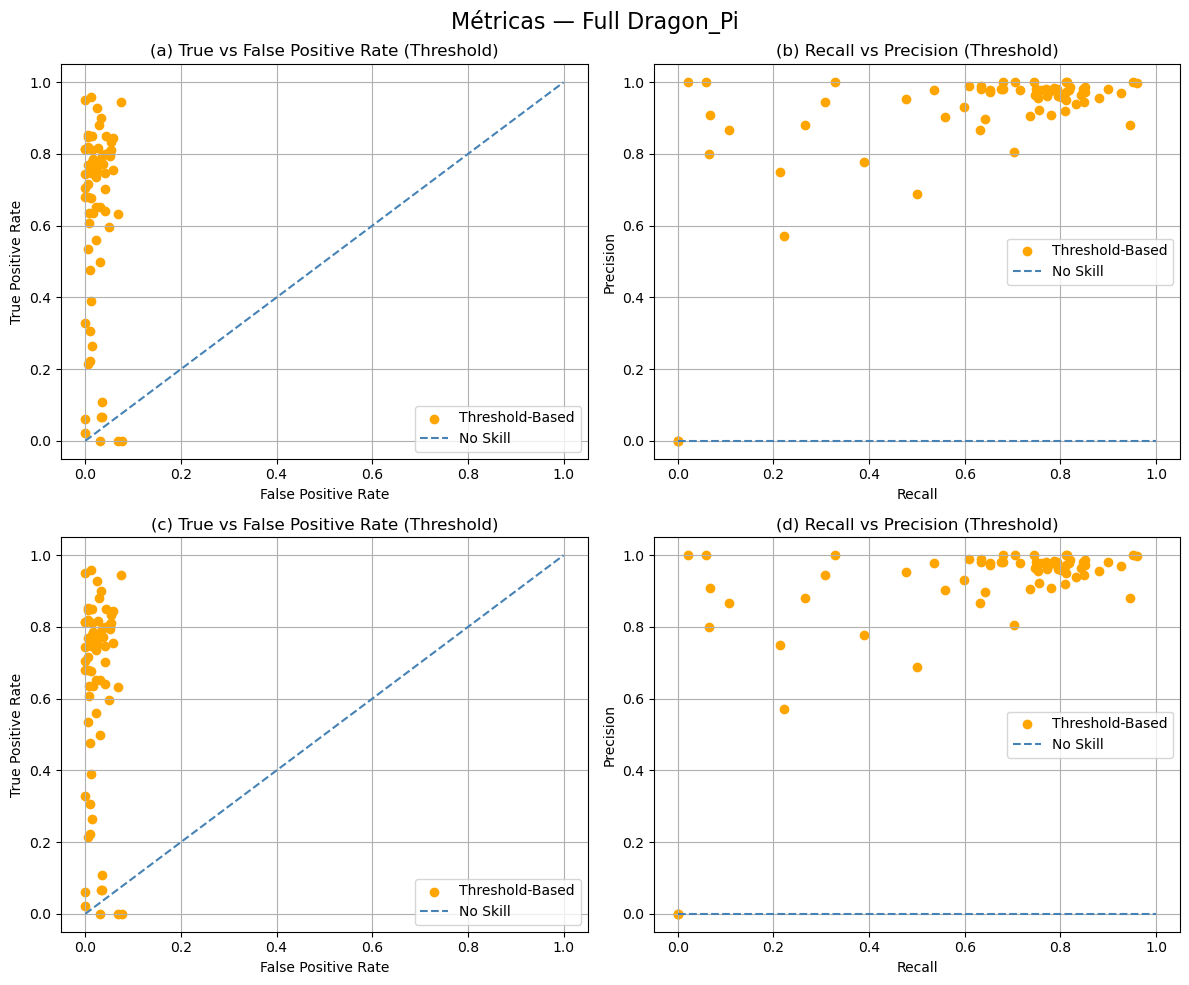

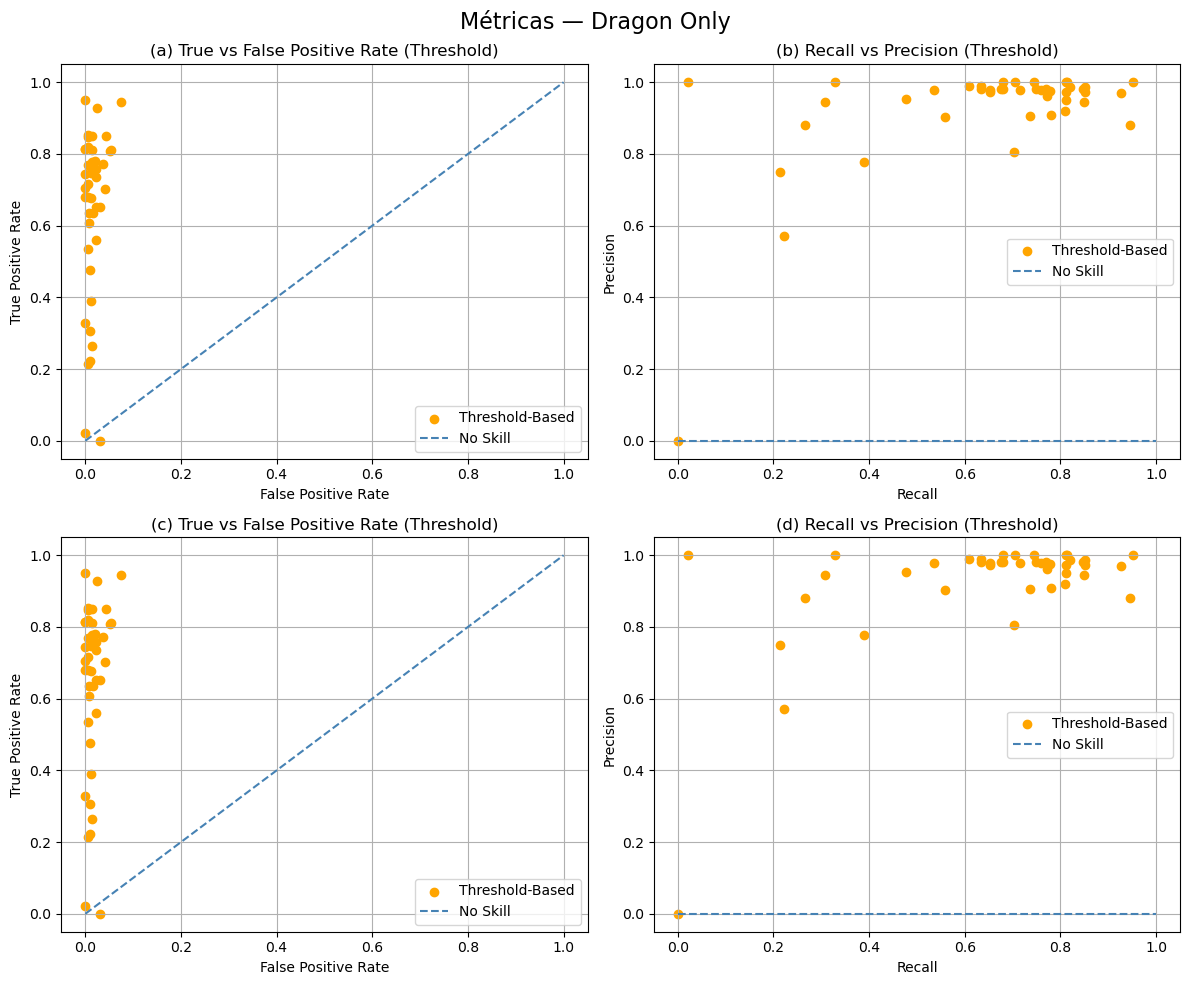

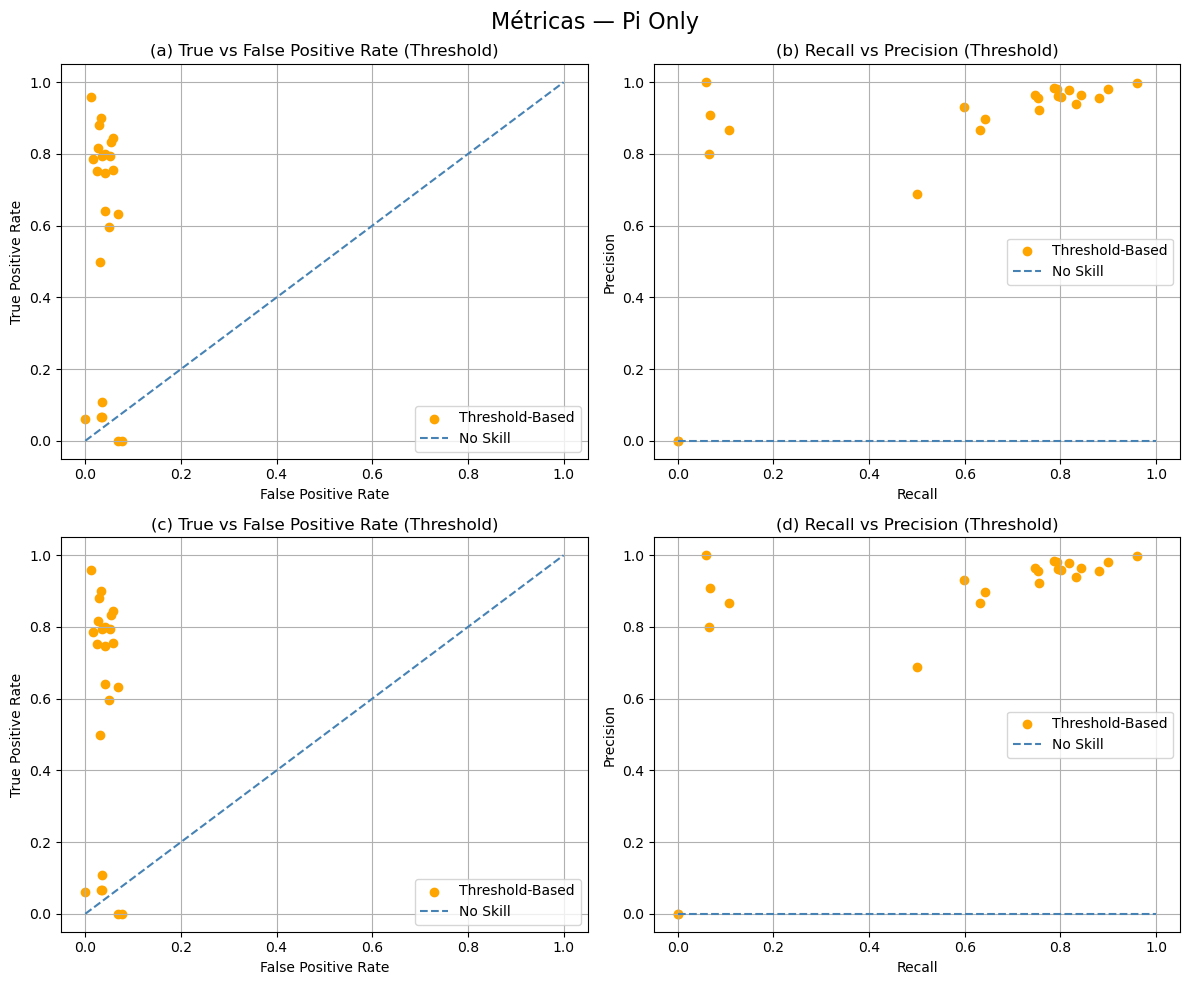

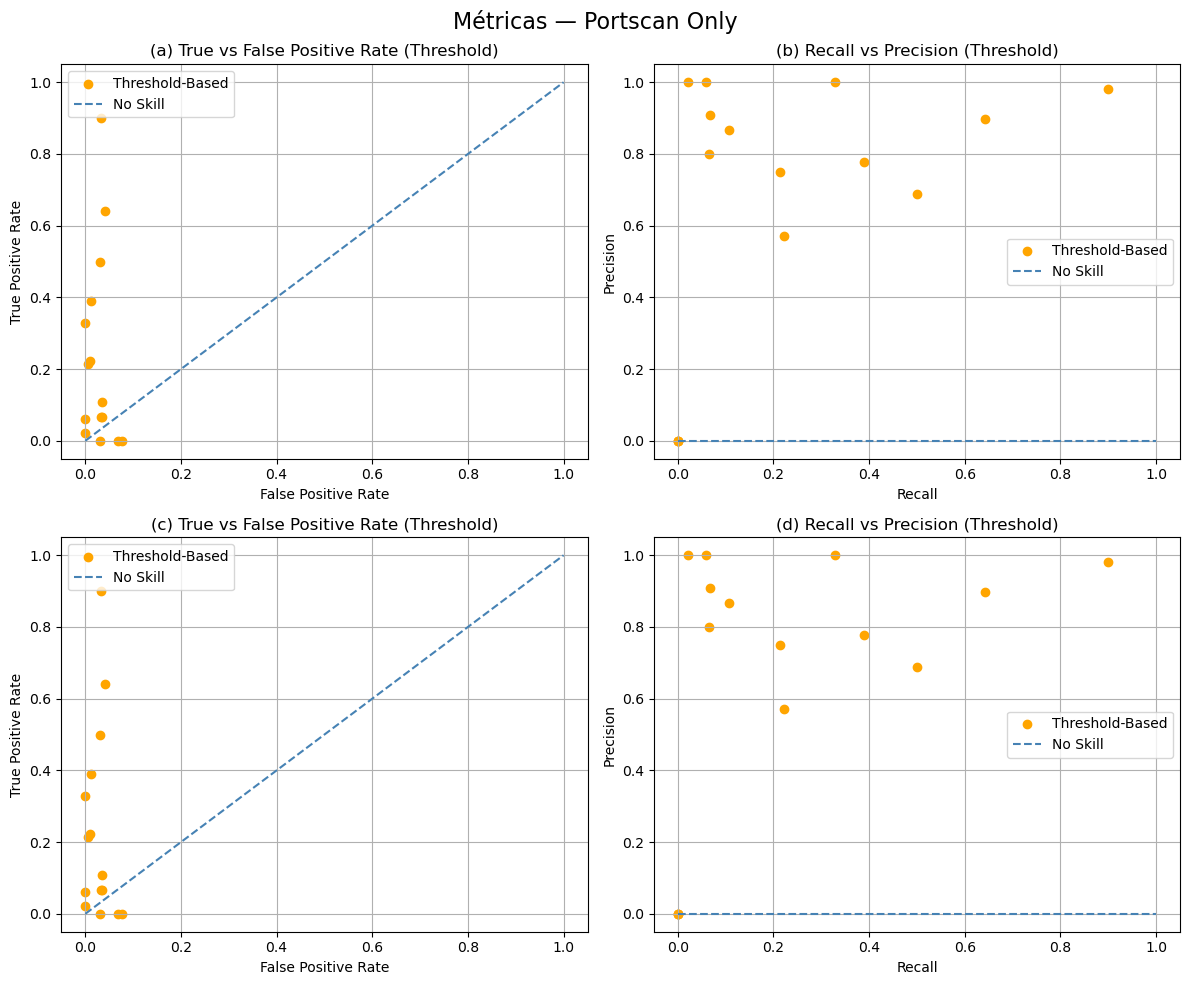

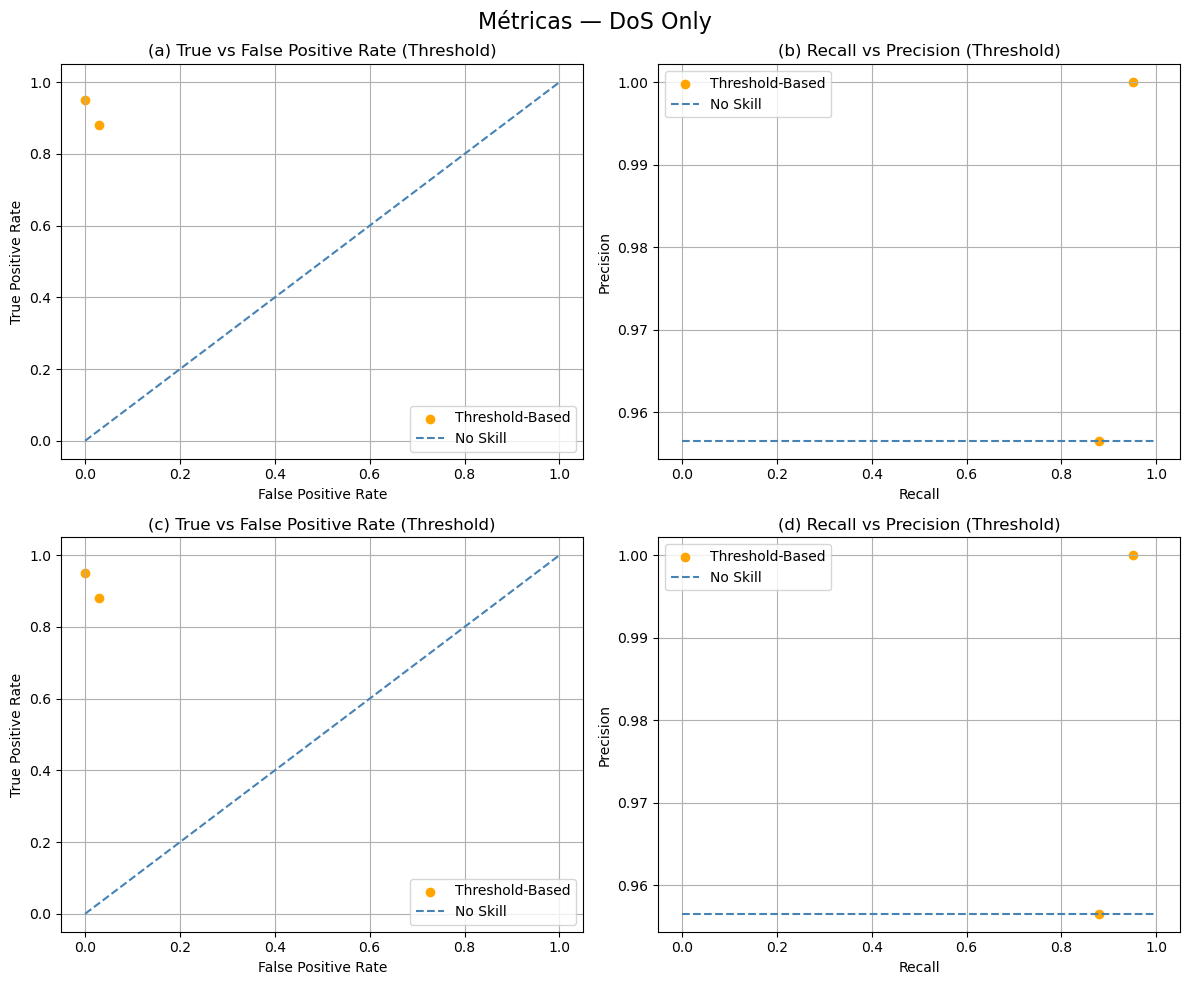

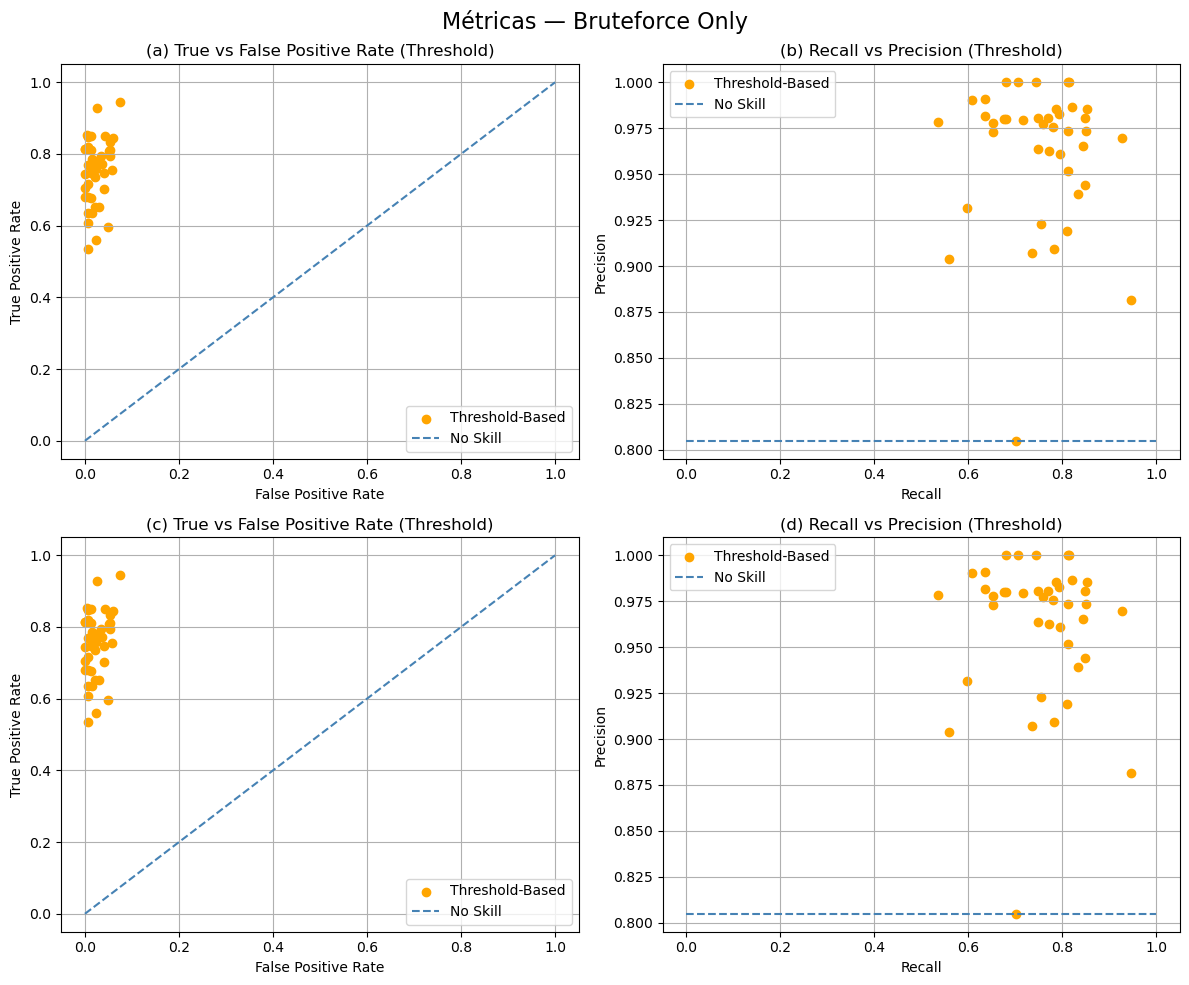

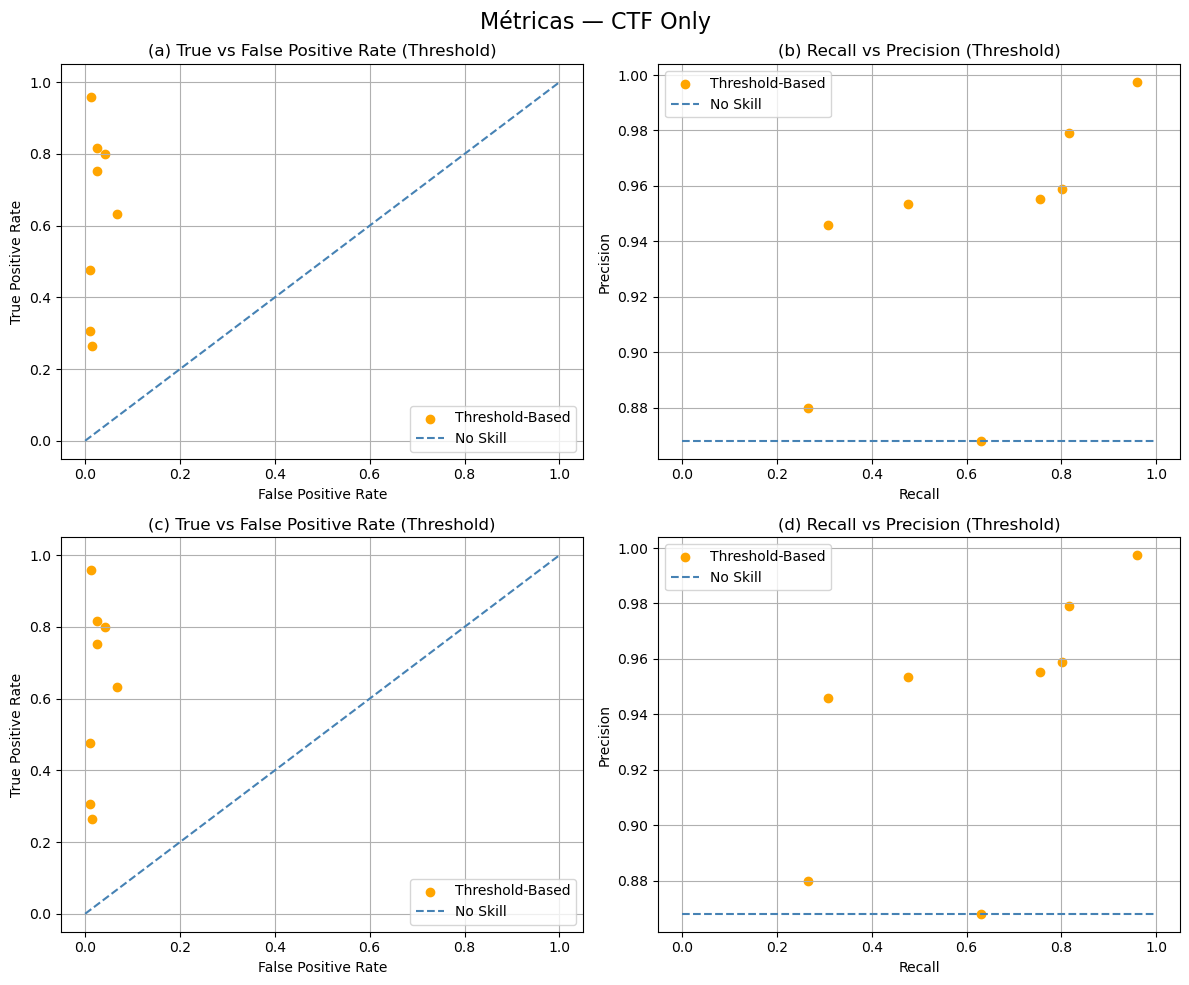

In [ ]:
def compute_metrics(df):
    df = df.copy()
    df["TPR"] = df["TP"] / (df["TP"] + df["FN"])
    df["FPR"] = df["FP"] / (df["FP"] + df["TN"])
    df["Precision"] = df["TP"] / (df["TP"] + df["FP"])
    df["Recall"] = df["TP"] / (df["TP"] + df["FN"])
    return df

def plot_style(df, title_prefix):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].scatter(df["FPR"], df["TPR"], color="orange", label="Threshold-Based")
    axs[0, 0].plot([0, 1], [0, 1], "--", color="steelblue", label="No Skill")
    axs[0, 0].set_title("(a) True vs False Positive Rate (Threshold)")
    axs[0, 0].set_xlabel("False Positive Rate")
    axs[0, 0].set_ylabel("True Positive Rate")
    axs[0, 0].legend()
    axs[0, 0].grid()

    axs[0, 1].scatter(df["Recall"], df["Precision"], color="orange", label="Threshold-Based")
    axs[0, 1].plot([0, 1], [df["Precision"].min()] * 2, "--", color="steelblue", label="No Skill")
    axs[0, 1].set_title("(b) Recall vs Precision (Threshold)")
    axs[0, 1].set_xlabel("Recall")
    axs[0, 1].set_ylabel("Precision")
    axs[0, 1].legend()
    axs[0, 1].grid()

    axs[1, 0].scatter(df["FPR"], df["TPR"], color="orange", label="Threshold-Based")
    axs[1, 0].plot([0, 1], [0, 1], "--", color="steelblue", label="No Skill")
    axs[1, 0].set_title("(c) True vs False Positive Rate (Threshold)")
    axs[1, 0].set_xlabel("False Positive Rate")
    axs[1, 0].set_ylabel("True Positive Rate")
    axs[1, 0].legend()
    axs[1, 0].grid()

    axs[1, 1].scatter(df["Recall"], df["Precision"], color="orange", label="Threshold-Based")
    axs[1, 1].plot([0, 1], [df["Precision"].min()] * 2, "--", color="steelblue", label="No Skill")
    axs[1, 1].set_title("(d) Recall vs Precision (Threshold)")
    axs[1, 1].set_xlabel("Recall")
    axs[1, 1].set_ylabel("Precision")
    axs[1, 1].legend()
    axs[1, 1].grid()

    fig.suptitle(f"Métricas — {title_prefix}", fontsize=16)
    plt.tight_layout()
    plt.show()

base_path = Path("results_threshold")
summary_files = list(base_path.rglob("summary.csv"))
rows = []

for file in summary_files:
    df = pd.read_csv(file)
    attack_dir = file.parent.name
    device = file.parent.parent.name
    attack_type = attack_dir.split("_")[-2] if "_" in attack_dir else attack_dir
    df["device"] = device
    df["attack_dir"] = attack_dir
    df["attack_type"] = attack_type
    rows.append(df)

results_df = pd.concat(rows, ignore_index=True)

group_map = {
    "Full Dragon_Pi": (results_df["device"].isin(["dragon", "pi"])),
    "Dragon Only": (results_df["device"] == "dragon"),
    "Pi Only": (results_df["device"] == "pi"),
    "Portscan Only": (results_df["attack_type"].str.contains("portscan", case=False)),
    "DoS Only": (results_df["attack_type"].str.contains("dos|synflood", case=False)),
    "Bruteforce Only": (results_df["attack_type"].str.contains("bruteforce", case=False)),
    "CTF Only": (results_df["attack_type"].str.contains("ctf", case=False)),
}

for group_name, mask in group_map.items():
    subset = results_df[mask]

    if subset.empty:
        print(f"Grupo {group_name}: sem dados.")
        continue

    df_metrics = compute_metrics(subset)
    plot_style(df_metrics, group_name)


The green triangular marker represents the **mean** value within each group.  
It complements the orange line (the **median**) by showing how the average compares to the central point of the distribution, helping to reveal skewness or imbalance in the data.

/tmp/ipykernel_149065/1682377042.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=labels, showmeans=True)


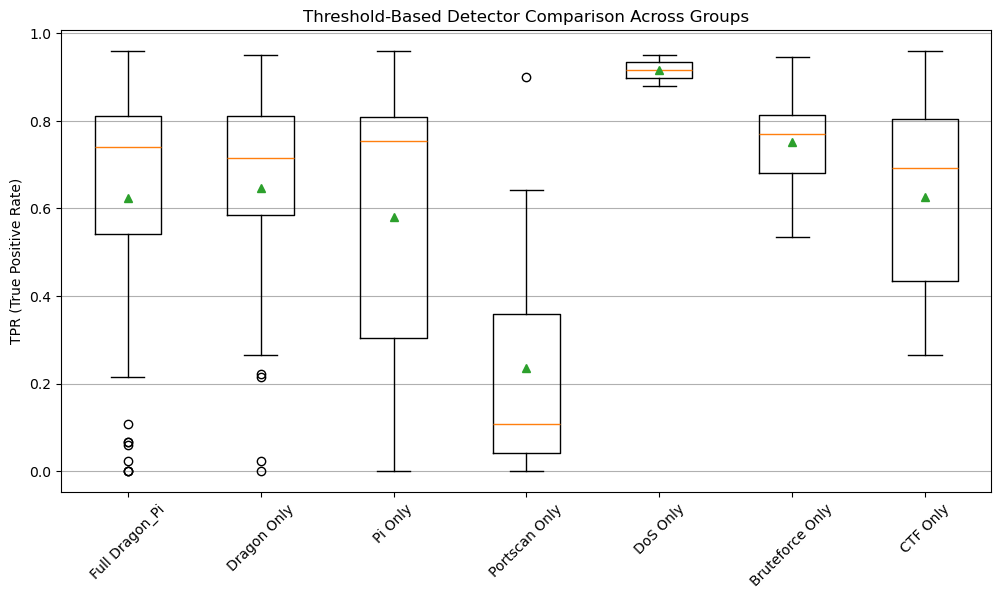

In [ ]:
boxplot_data = []
labels = []

for group_name, mask in group_map.items():
    subset = results_df[mask]

    if subset.empty:
        continue

    df_metrics = compute_metrics(subset)

    boxplot_data.append(df_metrics["TPR"].values)
    labels.append(group_name)

plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=labels, showmeans=True)

plt.title("Threshold-Based Detector Comparison Across Groups")
plt.ylabel("TPR (True Positive Rate)")
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.show()
